In [1]:
from mcts import mcts
from mcts import firstActionPolicy
from mcts import randomPolicy
from simulator import farmcell

import numpy as np
import matplotlib.pyplot as plt

In [30]:
# Re-initialize everything
n = 3
farm = np.zeros((n, n), dtype=int)
initialState = farmcell(n, (0, 0), farm)
m = mcts(iterationLimit=20, rolloutPolicy=randomPolicy)
rewards = []
full_tree_over_time = []

In [31]:
epochs = 100
last_round_farm = None
for i in range(epochs):
    bestAction = m.search(initialState=initialState)
    last_state, full_tree = m.optimal_rollout()
    full_tree_over_time.append(1 if full_tree else 0)
    last_round_farm = last_state.state.farm
    reward = last_state.state.getReward()
    rewards.append(reward)

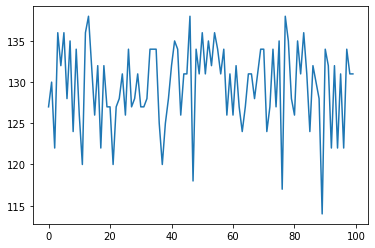

In [32]:
plt.plot(rewards)

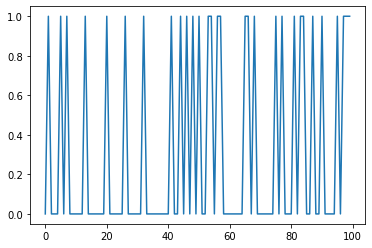

In [33]:
plt.plot(full_tree_over_time)